# Project Goal

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), build a model that can predict whether or not a borrower will pay back their loan. Then, in the future when the company gets a new potential customer, it can assess whether or not that customer is likely to pay back the loan.

The "loan_status" column contains the target variable.

### Get the LendingClub data info
It's not very clear what some of the column names mean, so create a function that returns a longer description of each feature.

In [1]:
import pandas as pd
import numpy as np

data_info = pd.read_csv('Data/lending_club_info.csv', index_col='LoanStatNew')

In [2]:
# Function that returns the description of a feature

def get_feature_info(feature_name):
    print(data_info.loc[feature_name]['Description'])

In [3]:
get_feature_info('revol_util')

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


### Get the actual LendingClub data

In [4]:
df = pd.read_csv('Data/lending_club_loan_two.csv')

In [5]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


-------------
## Data Cleaning and Feature Engineering

#### *The target variable is currently represented as 'Fully Paid' or 'Charge Off'.  Change these target labels to binary ints.*

In [6]:
df['loan_status'].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

In [7]:
# 0 means the individual paid the loan; 1 means the individual defaulted
df['loan_status'] = df['loan_status'].apply(lambda status: 0 if status == 'Fully Paid' else 1)

In [8]:
df['loan_status'].unique()

array([0, 1])

### Next, deal with missing data.
I will investigate the features that contain null values to determine if they should be dropped, filled, or used to create other features.

In [9]:
# Show which features contain null values, and if they do, how many
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [10]:
# Investigate 'employment title'
get_feature_info('emp_title')
print('\n')
print(df['emp_title'].value_counts())
print('\n')
print('# of null entries: ', df['emp_title'].isnull().sum())

The job title supplied by the Borrower when applying for the loan.*


Teacher                             4389
Manager                             4250
Registered Nurse                    1856
RN                                  1846
Supervisor                          1830
                                    ... 
Aston Hotels & Resorts                 1
William Morris                         1
Zeno Office Solutions                  1
court bailiff                          1
Senior Claims Benefit Specialist       1
Name: emp_title, Length: 173105, dtype: int64


# of null entries:  22927


#### Because there are so many null entries and so many unique job titles, I will create a binary variable called "emp_title_known" that will indicate whether or not the applicant's job title is known.

In [11]:
# 1 for job title known; 0 for unknown
df['emp_title_known'] = df['emp_title'].apply(lambda title: 1 if type(title) == str else 0)

# Drop the old column
df.drop('emp_title', axis=1, inplace=True)

In [12]:
df.head(1)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,emp_title_known
0,10000.0,36 months,11.44,329.48,B,B4,10+ years,RENT,117000.0,Not Verified,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1


In [13]:
# Investigate "emp_length"
print(df['emp_length'].value_counts())
print('\n')
print(df['emp_length'].isnull().sum())

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64


18301


#### There are only 11 unique categories for the "emp_length" variable, so it's feasible to create dummy variables out of them. However, first investigate the ratio of default to fully paid grouped by employment length to determine if there is sufficient variance in this feature to keep it around.

In [14]:
import matplotlib.pyplot as plt

In [15]:
emp_co = df[df['loan_status'] == 0].groupby('emp_length').count()['loan_status']
emp_fp = df[df['loan_status'] == 1].groupby('emp_length').count()['loan_status']

In [16]:
emp_len = emp_co / emp_fp

<AxesSubplot:xlabel='emp_length'>

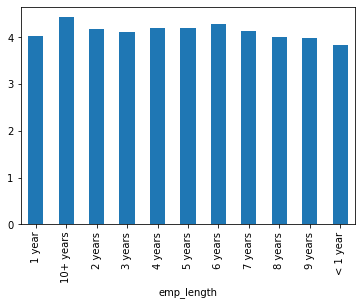

In [17]:
emp_len.plot(kind='bar')

#### There's not much of a difference between the default-to-paid ratios across different employment length groups. Thus, I will drop the 'emp_length' column.

In [18]:
df.drop('emp_length', axis=1, inplace=True)

In [19]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
emp_title_known             0
dtype: int64

In [20]:
# Investigate "title"
get_feature_info('title')

The loan title provided by the borrower


In [21]:
# The description above sounds similar to the purpose of a loan.
get_feature_info('purpose')

A category provided by the borrower for the loan request. 


In [22]:
df['title'].value_counts()

Debt consolidation               152472
Credit card refinancing           51487
Home improvement                  15264
Other                             12930
Debt Consolidation                11608
                                  ...  
To get rid of those things            1
debt consolidation #1                 1
credit cards/home improvement         1
Kangen water appliance                1
Connor improvements                   1
Name: title, Length: 48817, dtype: int64

In [23]:
df['purpose'].value_counts()

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

#### "title" turns out to be a repeat of "purpose" but with null values. Drop the 'title' column.

In [24]:
df.drop('title', axis=1, inplace=True)

In [25]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
emp_title_known             0
dtype: int64

#### revol_bal and pub_rec_bankruptcies have very few null values. See what fraction of total values are null.

In [26]:
# Investigate "revolv_util"
df.isnull().sum()['revol_util'] / len(df)

0.0006969169002348307

In [27]:
# Investigate "pub_rec_bankruptcies"
df.isnull().sum()['pub_rec_bankruptcies'] / len(df)

0.0013509077595131682

#### Because revolv_util and pub_rec_bankruptcies both have such a small percentages of instances that are null, I'll just drop those null instances. This will remove a small number of rows from my dataframe.

In [28]:
df = df.dropna(subset=['revol_util', 'pub_rec_bankruptcies'])

In [29]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                  0
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37205
pub_rec_bankruptcies        0
address                     0
emp_title_known             0
dtype: int64

In [30]:
# Investigate "mort_acc"
get_feature_info('mort_acc')

Number of mortgage accounts.


In [31]:
df['mort_acc'].value_counts()

0.0     139708
1.0      60384
2.0      49907
3.0      38022
4.0      27865
5.0      18182
6.0      11059
7.0       6050
8.0       3120
9.0       1653
10.0       863
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

#### There is a lot of missing data and the range of this feature's values is vast, so simply filling the missing values with the average value of the feature probably won't work. One thing I could do is create a linear regression that uses the other numerical features to predict the missing mort_acc values. A simpler solution would be to find the feature that mort_acc is most highly correlated with and just use that feature to impute the missing mort_acc values. I will take the latter approach.

In [32]:
df.corr()['mort_acc'].sort_values(ascending=False)

mort_acc                1.000000
total_acc               0.381205
annual_inc              0.236277
loan_amnt               0.222381
revol_bal               0.195063
installment             0.193752
open_acc                0.109440
pub_rec_bankruptcies    0.027273
pub_rec                 0.011576
revol_util              0.007514
emp_title_known        -0.021722
dti                    -0.025401
loan_status            -0.073048
int_rate               -0.082656
Name: mort_acc, dtype: float64

#### 'total_acc' is the feature most correlated with mort_acc. Therefore, I will group the dataframe by total_acc and for each of these total_acc groups, calculate the mean mort_acc. Then I can use this data as a lookup table to impute missing mort_acc values. More concretely, to impute a missing mort_acc value, I will simply take that instance's total_acc value and look up the associated average mort_acc value in the table.

In [33]:
get_feature_info('total_acc')

The total number of credit lines currently in the borrower's credit file


In [34]:
df['total_acc'].value_counts()

21.0     14257
22.0     14235
20.0     14193
23.0     13899
24.0     13855
         ...  
100.0        1
115.0        1
118.0        1
108.0        1
104.0        1
Name: total_acc, Length: 118, dtype: int64

In [35]:
mort_acc_impute_table = df.groupby('total_acc').mean()['mort_acc']

In [36]:
# This function will be applied to the mort_acc column.
def fill_missing_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return mort_acc_impute_table[total_acc]
    else:
        return mort_acc

In [37]:
mort_acc_impute_table[df.loc[0]['total_acc']]

1.8991868569532029

In [38]:
# Apply the function to the "mort_acc" column
df['mort_acc'] = df.apply(lambda x: fill_missing_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [39]:
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
emp_title_known         0
dtype: int64

The data now contains only non-null values.

### My next task will be to convert numerical columns in non-numerical form into purely numerical form. I will also numerically encode categorical columns using dummy variables or an ordinal encoding.

In [40]:
# Find the features that are non-numerical
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [41]:
# Investiage "term"
df['term'].value_counts()

 36 months    301247
 60 months     93972
Name: term, dtype: int64

#### Although "term" is a categorical variable, it can be represented as a number and has a natural ordinal encoding. So I will simply change the strings to ints.

In [42]:
# Change these strings into ints
df['term'] = df['term'].apply(lambda term: int(term.strip()[:2]))

In [43]:
df['term'].value_counts()

36    301247
60     93972
Name: term, dtype: int64

In [44]:
# Investigate "grade"
df['grade'].value_counts()

B    115812
C    105775
A     64056
D     63364
E     31427
F     11740
G      3045
Name: grade, dtype: int64

In [45]:
# Investigate "sub_grade" variable
df['sub_grade'].value_counts()

B3    26611
B4    25558
C1    23609
C2    22541
B2    22457
B5    22046
C3    21178
C4    20232
B1    19140
A5    18500
C5    18215
D1    15947
A4    15763
D2    13916
D3    12196
D4    11625
A3    10537
A1     9717
D5     9680
A2     9539
E1     7906
E2     7410
E3     6196
E4     5354
E5     4561
F1     3530
F2     2756
F3     2277
F4     1782
F5     1395
G1     1057
G2      752
G3      552
G4      371
G5      313
Name: sub_grade, dtype: int64

#### Because the grade information is fully reprsented in the subgrade data, the grade feature is redundant. Thus, remove the grade column.

In [46]:
df.drop('grade', axis=1, inplace=True)

#### *Create dummy variables for the sub_grade column*

In [47]:
sub_grade_dummies = pd.get_dummies(df['sub_grade'], drop_first=True)

In [48]:
# Concatenate these dummy variables to df and drop the old column
df = pd.concat([df, sub_grade_dummies], axis=1)
df.drop('sub_grade', axis=1, inplace=True)

In [49]:
df.columns # Check the new column names

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address',
       'emp_title_known', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4',
       'G5'],
      dtype='object')

In [50]:
# Investigate "home_ownership"
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

#### There are few enough unique categories to create dummy variables. First, group 'NONE' and 'ANY' into 'OTHER', then create dummy variables for this feature.

In [51]:
df['home_ownership'] = df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

In [52]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          142
Name: home_ownership, dtype: int64

In [53]:
home_ownership_dummies = pd.get_dummies(df['home_ownership'], drop_first=True) # create dummies
df = pd.concat([df, home_ownership_dummies], axis=1) # add dummies to df

In [54]:
df.drop('home_ownership', axis=1, inplace=True)

In [55]:
# Investigate "verification_status"
get_feature_info('verification_status')
print('\n')
print(df['verification_status'].value_counts())

Indicates if income was verified by LC, not verified, or if the income source was verified


Verified           139451
Source Verified    131301
Not Verified       124467
Name: verification_status, dtype: int64


In [56]:
# There are few enough unique categories, so create dummy variables
verification_dummies = pd.get_dummies(df['verification_status'], drop_first=True)

In [57]:
df.drop('verification_status', axis=1, inplace=True)
df = pd.concat([df, verification_dummies], axis=1)

In [58]:
# Investigate "issue_d"
get_feature_info('issue_d')

The month which the loan was funded


#### You should definitely get rid of this feature because it indicates whether or not the loan was funded which we don't want to know when training the model. This is a form of data leakage, so remove this feature.

In [59]:
df.drop('issue_d', axis=1, inplace=True)

In [60]:
# Check which non-numerical variables remain
df.select_dtypes(['object']).columns

Index(['purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [61]:
# Investigate "purpose"
print(df['purpose'].value_counts())
print('\n')
print(df['purpose'].nunique(), ' unique categories')

debt_consolidation    234169
credit_card            82923
home_improvement       23961
other                  21059
major_purchase          8756
small_business          5656
car                     4670
medical                 4175
moving                  2842
vacation                2442
house                   2197
wedding                 1794
renewable_energy         329
educational              246
Name: purpose, dtype: int64


14  unique categories


In [62]:
# There are few enough categories, so create dummy variables
purpose_dummies = pd.get_dummies(df['purpose'], drop_first=True)

In [63]:
df.drop('purpose', axis=1, inplace=True)
df = pd.concat([df, purpose_dummies], axis=1)

In [64]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',
       'loan_status', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address',
       'emp_title_known', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4',
       'G5', 'OTHER', 'OWN', 'RENT', 'Source Verified', 'Verified',
       'credit_card', 'debt_consolidation', 'educational', 'home_improvement',
       'house', 'major_purchase', 'medical', 'moving', 'other',
       'renewable_energy', 'small_business', 'vacation', 'wedding'],
      dtype='object')

In [65]:
# Investigate "earliest_cr_line"
get_feature_info('earliest_cr_line')
print('\n')
df['earliest_cr_line'].value_counts()

The month the borrower's earliest reported credit line was opened




Oct-2000    3013
Aug-2000    2930
Oct-2001    2890
Aug-2001    2879
Nov-2000    2729
            ... 
Jul-1958       1
Jun-1955       1
May-1962       1
Jul-1951       1
Feb-1961       1
Name: earliest_cr_line, Length: 684, dtype: int64

#### There are too many unique Month-Year combinations. However, I can extract the year from these date strings and store them as ints so they can serve as ordinal categories.

In [66]:
int(df['earliest_cr_line'][0].split('-')[-1])

1990

In [67]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date.split('-')[-1]))

In [68]:
# Check which non-numerical variables remain
df.select_dtypes(['object']).columns

Index(['initial_list_status', 'application_type', 'address'], dtype='object')

In [69]:
# Investigate "initial_list_status"
get_feature_info('initial_list_status')

The initial listing status of the loan. Possible values are – W, F


In [70]:
# This feature only has 2 possible values, so make dummy variables
initial_list_status_dummies = pd.get_dummies(df['initial_list_status'], drop_first=True)

In [71]:
df.drop('initial_list_status', axis=1, inplace=True)
df = pd.concat([df, initial_list_status_dummies], axis=1)

In [72]:
# Investigate "application_type"
get_feature_info('application_type')

Indicates whether the loan is an individual application or a joint application with two co-borrowers


In [73]:
df['application_type'].value_counts()

INDIVIDUAL    394508
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [74]:
# Make dummies
app_type_dummies = pd.get_dummies(df['application_type'], drop_first=True)

In [75]:
df = pd.concat([df, app_type_dummies], axis=1)
df.drop('application_type', axis=1, inplace=True)

In [76]:
# Check which non-numerical variables remain
df.select_dtypes(['object']).columns

Index(['address'], dtype='object')

In [77]:
# Investigate "address"
print(df['address'].nunique())
df['address'].head(3)

392898


0       0174 Michelle Gateway\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
Name: address, dtype: object

#### "address" proabably won't tell us much without more domain knowledge. Zip code may be helpful, but there is no ordinal encoding to these numbers, so they won't be useful as ints. Pehaps they could be useful as categories. See if the number of unique zip codes is small enough to encode them as categorical dummy variables.

In [78]:
# Extract the zip codes from the address strings
df['zip_code'] = df['address'].apply(lambda address: address.split()[-1])

In [79]:
df['zip_code'].value_counts()

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zip_code, dtype: int64

#### There are only 10 unique zip codes, which is actually a very managable number. Therefore, I will create dummy variables.

In [80]:
zip_dummies = pd.get_dummies(df['zip_code'], drop_first=True)

In [81]:
df = pd.concat([df, zip_dummies], axis=1)

In [82]:
# Drop 'address' and 'zip_code'
df.drop(['address', 'zip_code'], axis=1, inplace=True)

#### The dataset has been cleared of null values and all the categorical features have been encoded numerically.

In [83]:
df.columns # The column names of the cleaned dataframe

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',
       'loan_status', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'emp_title_known', 'A2', 'A3', 'A4', 'A5', 'B1',
       'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3',
       'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5',
       'G1', 'G2', 'G3', 'G4', 'G5', 'OTHER', 'OWN', 'RENT', 'Source Verified',
       'Verified', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation', 'wedding',
       'w', 'INDIVIDUAL', 'JOINT', '05113', '11650', '22690', '29597', '30723',
       '48052', '70466', '86630', '93700'],
      dtype='object')

In [84]:
df.shape

(395219, 80)

-------

## Now that the data has been cleaned and entirely set to numerical features, I can begin splitting the data into training and test sets and build my model.

In [235]:
X = df.drop('loan_status', axis=1) # Select only the predictor features for the input data
y = df['loan_status'].values # select the labels for your y values

In [236]:
y[:5]

array([0, 0, 0, 0, 1])

In [237]:
print(X.shape)
print(y.shape)

(395219, 79)
(395219,)


In [238]:
y.sum() / len(y)

0.19615200686201828

About 20% of the loans in the dataset defaulted. This means that there is a class imbalance in the dataset. In order to make the model sensitive to this imbalance, I will pass a dict to the class_weight argument of the Keras .fit() method.

#### *Split data into training, validation, and test sets*

In [240]:
from sklearn.model_selection import train_test_split

# Set stratify=y to maintain class balance across datasets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.1, stratify=y, random_state=42)

In [241]:
# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [242]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(284557, 79)
(71140, 79)
(39522, 79)
(284557,)
(71140,)
(39522,)


In [243]:
# Check that the class balance is roughly the same across sets
print(y_train.sum() / len(y_train))
print(y_valid.sum() / len(y_valid))
print(y_test.sum() / len(y_test))

0.1966706143233166
0.19408209165026707
0.19614391984211324


#### *Normalize the input variables using MinMaxScaler*

In [244]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

# DO NOT FIT SCALER TO VALIDATION OR TEST DATA; ONLY TRANSFORM THESE DATASETS
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Build the model

In [245]:
import tensorflow as tf
import tensorflow.keras as keras

I've added Batch Normalization layers to speed up training. The activations, kernel initializations, and optimizer are some defaults I usually start with that I discovered while reading the book *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*.

In [307]:
from tensorflow.keras import layers

keras.backend.clear_session()
tf.random.set_seed(42)

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, input_dim=X_train.shape[1], activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

In [308]:
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

#### *Use Early Stopping to reduce overfitting.*

In [309]:
from tensorflow.keras.callbacks import EarlyStopping

early_cb = EarlyStopping(patience=75)

#### *Define a class weights dictionary*

There is a class imbalance in the dataset, with far fewer instances of default than "fully paid". The ratio of default to fully paid is around 1 to 4, so if the classifier just guesses the "fully paid" class every time, it would achieve an accuracy of around 80%. However, as a lender, the company is primarily interested in being able to detect when an application is likely to result in a default. So the company doesn't care about the accuracy of the classifier as much as it cares about the classifier's positive class recall score, which is the percentage of loan defaults in the dataset that the model actually detects. 

This preference for detecting the minority class means the company is content with making false positive errors (misclassifying truly good loan applications as defaults) if it means that it can minimize false negative errors (misclassifying a loan application that will actually default as a good loan). This tradeoff will lead to a lower overall accuracy score in favor of a higher recall score.

To emphasize the importance of classifying the positive (loan default) class correctly, I will pass a dictionary to the class_weight argument of the .fit() method. This dictionary will contain the class labels as keys and their weights/importances as values.

In [310]:
class_weight = {0: 1, 1: 10}

### Train the model

In [311]:
# Train for 500 epochs with early stopping; pass the class_weight dict as an argument so the model is sensitive
# of the class imbalance
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), class_weight=class_weight,
                    callbacks=[early_cb])

Epoch 1/500
8893/8893 [==============================] - 48s 5ms/step - loss: 0.9188 - accuracy: 0.6354 - val_loss: 0.5742 - val_accuracy: 0.5933
Epoch 2/500
8893/8893 [==============================] - 49s 5ms/step - loss: 0.8779 - accuracy: 0.6420 - val_loss: 0.5076 - val_accuracy: 0.6757
Epoch 3/500
8893/8893 [==============================] - 48s 5ms/step - loss: 0.8718 - accuracy: 0.6394 - val_loss: 0.5273 - val_accuracy: 0.6622
Epoch 4/500
8893/8893 [==============================] - 48s 5ms/step - loss: 0.8671 - accuracy: 0.6425 - val_loss: 0.5359 - val_accuracy: 0.6481
Epoch 5/500
8893/8893 [==============================] - 48s 5ms/step - loss: 0.8649 - accuracy: 0.6441 - val_loss: 0.4972 - val_accuracy: 0.6566
Epoch 6/500
8893/8893 [==============================] - 48s 5ms/step - loss: 0.8622 - accuracy: 0.6436 - val_loss: 0.5047 - val_accuracy: 0.6992
Epoch 7/500
8893/8893 [==============================] - 48s 5ms/step - loss: 0.8616 - accuracy: 0.6489 - val_loss: 0.5441 -

In [315]:
# Save the model
model.save('lending_club_model.h5')

#### *Evaluate the model's performance on the training and evaluate its generalization on the test set.*

In [312]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [313]:
predictions = model.predict_classes(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76    228593
           1       0.38      0.93      0.54     55964

    accuracy                           0.69    284557
   macro avg       0.68      0.78      0.65    284557
weighted avg       0.86      0.69      0.72    284557



In [314]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75     31770
           1       0.36      0.89      0.51      7752

    accuracy                           0.67     39522
   macro avg       0.66      0.75      0.63     39522
weighted avg       0.84      0.67      0.70     39522



In [316]:
print(confusion_matrix(y_test, predictions))

[[19549 12221]
 [  861  6891]]


#### The model only achieved 69% accuracy on the training set and 67% accuracy on the test set. However, remember that accuracy is not the most important metric for this task. The most important metric is recall. Recall is the proportion of positive instances in the dataset that the model detects and correctly classifies as positive. In this case, recall means the proportion of defaults in the dataset that were correctly flagged by the model. Defaults are expensive for a lending company, so high recall is important because it means the company will be able to identify more loans that actually default and save itself money. On the test set, this model achieved 89% recall, which means that out of all the defaulted loans in the unseen data, the model detected 89% of them. 

## Conclusion

After getting the data into the proper form, I build a Keras neural net model that could classify loans as either likely to be fully repaid or likely to default. After being trained for 94 epochs, the model achieved fairly mediocre accuracies of 69% and 67% on the training and test sets respectively. However, accuracy is not the most important metric because the dataset had a class imbalance and the cost of false positives and false negatives was not equal. Loan defaults are expensive to a lender, so it wants to make as few false negative errors (misclassifying a loan application that will actually default as a good loan) as possible. Therefore, the proper measure of this classifier's performance is its positive class recall. On this metric, the model achieved 93% and 89% recall on the training and test sets respectively. This means that the model is good at detecting the loans that will actually default.

This high recall score did come at the expense of the overall accuracy of the classifier. I ran this model a few times before adding class weights to emphasize the positive class, and these models achieved accuracies over 90% but had recall scores between 40%-50%. Given that the task of the model is to identify good and bad loans, this recall was simply too low. When I added class weights, the recall increased drastically at the expense of the overall accuracy. This is because the model started to flag more instances as likely defaults, leading to more false positive errors but fewer false negatives. This tradeoff should be fine though given the real world application of this model. A lender would rather have its software incorrectly flag a loan as a likely default then have a human analyst give it a second opinion than have the software incorrectly say the loan is good then end up having the borrower default.

One final note, training set recall reached 93% by the time the early stopping callback stopped the model's training. I could go back and continue to let the model train and its recall would continue to increase, but its accuracy would likely start falling more sharply. At this point it would be up the the end user of this system to choose the ideal recall-precision-accuracy tradeoff and proceed accordingly.